## System/Enviroment Checking 

In [5]:
#checking the environment (Kaggle or local)

import os
import sys

print("Current working directory:", os.getcwd())
print("Python executable:", sys.executable)
print("Home directory:", os.path.expanduser("~"))

# Check if Kaggle environment variable exists
if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
    print("✅ Running inside Kaggle environment.")
else:
    print("❌ Not running inside Kaggle environment.")

Current working directory: /kaggle/working
Python executable: /usr/bin/python3
Home directory: /root
✅ Running inside Kaggle environment.


In [6]:
# kaggle specific check

import os

print("Contents of /kaggle:")
for folder in os.listdir("/kaggle"):
    print(" -", folder)

Contents of /kaggle:
 - lib
 - input
 - working


In [7]:
# List all files in /kaggle/input such that we can see the datasets available (Kaggle only[CSV files])

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tourasa-dataset-recommendation/cairo_giza_landmarks.csv
/kaggle/input/tourasa-dataset-recommendation/user_preferences_budget_consistent_5M.xls


## Libraries importation

In [8]:
pip install lightfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp311-cp311-linux_x86_64.whl size=831129 sha256=ce86e6f1afc3c3eaa8537bfd0e632f92cbd0fc5f4a39e55f987fba32a2c1e59a
  Stored in directory: /root/.cache/pip/wheels/b9/0d/8a/0729d2e6e3ca2a898ba55201f905da7db3f838a33df5b3fcdd
Successfully built lightfm
Note: you may need to restart the kernel to use updated packages.


In [9]:
# used Libraries importation

import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from itertools import combinations
from collections import Counter
from lightfm import LightFM
from lightfm.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from sklearn.metrics import mean_squared_error

### Dataset preparation and preprocessing

In [10]:
DATA_PATH = "/kaggle/input/tourasa-dataset-recommendation/"

In [11]:
df_landmarks = pd.read_csv(f"{DATA_PATH}cairo_giza_landmarks.csv")

df_user_travel = pd.read_csv(f"{DATA_PATH}user_preferences_budget_consistent_5M.xls")

In [12]:
df_landmarks

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,city,name,subcategory,rating,ranking,address,latitude,longitude
0,Cairo,The Egyptian Museum in Cairo,Museums,4.5,#1 of 335 things to do in Cairo,"Midan El Tahrir Geographical Society Building,...",30.047327,31.233646
1,Cairo,Nile River,Nature & Parks,4.5,#19 of 335 things to do in Cairo,Cairo 15662 Egypt,23.972813,32.874940
2,Cairo,Coptic Cairo,Sights & Landmarks,4.5,#8 of 335 things to do in Cairo,"Kasr Al Shama'e, Cairo Egypt",30.005342,31.232689
3,Cairo,Mosque of Muhammad Ali,Sights & Landmarks,4.5,#5 of 335 things to do in Cairo,"Al Abageyah El Khalifa, Cairo 4252360 Egypt",30.029100,31.259820
4,Cairo,Al-Azhar Park,Nature & Parks,4.5,#12 of 335 things to do in Cairo,"Salah Salem St Al Darassa Hill, Cairo 4294010 ...",30.040789,31.264729
...,...,...,...,...,...,...,...,...
585,Giza,Maisa Gallery,Shopping,NaN,NaN,"13 El Batal Ahmed Abdel Aziz St. Mohandeseen, ...",29.981690,31.209590
586,Giza,Didi Gallery,Shopping,NaN,NaN,"84 Shehab St. Mohandeseen, Giza Egypt",30.058500,31.198910
587,Giza,Gallery Albert,Shopping,NaN,NaN,"12 Yemen St. Mohandeseen, Giza Egypt",30.009060,31.198980
588,Giza,Distillery Tours,Tours,NaN,NaN,NaN,NaN,NaN


In [13]:
df_user_travel

,User_id,User_age,User_gender,user_preferences,user_budget_tier,landmark_budget_tier,category,rating,landmark_name,user_travel_type,landmaek_travel_type
0,1,50,female,Zoos & Aquariums,Medium,low,Nightlife,3.1,Wine Bars,solo,solo;couple;luxury;Medium
1,2,30,male,Museums;Shopping;Zoos & Aquariums,high,high,Sights & Landmarks,4.4,Masjid Al-shaykh Mutahhar,luxury,family;Medium
2,3,52,female,Food & Drink;Nature & Parks;Traveler Resources,Medium,Medium,Nature & Parks,4.4,Nile River,family,family;low budget;solo;couple
3,4,75,male,Fun & Games;Shopping,Medium,low,Sights & Landmarks,2.1,Orman Park,medium budget,solo;couple
4,5,21,male,Shopping,high,low,Shopping,3.6,El Mashrabia Art Gallery,luxury,Medium;couple
...,...,...,...,...,...,...,...,...,...,...,...
4999995,4999996,37,male,Museums;Spas & Wellness,Medium,Medium,Museums,4.4,Taha Hussein Museum,medium budget,family;solo;couple;Medium
4999996,4999997,42,female,Shopping,Medium,Medium,Shopping,3.4,Easel & Camera Contemporary Art Gallery,solo,Medium;couple
4999997,4999998,21,male,Shopping;Sights & Landmarks,Medium,Medium,Sights & Landmarks,3.2,Al-Hakim Mosque,solo,solo;Medium
4999998,4999999,23,female,Concerts & Shows;Nature & Parks;Nightlife,Medium,low,Outdoor Activities,4.1,"Surfing, Windsurfing & Kitesurfing",medium budget,solo;Medium


In [14]:
df_user_travel_to_use = df_user_travel.drop(columns=["User_id"])

In [15]:
df_user_travel_to_use

,User_age,User_gender,user_preferences,user_budget_tier,landmark_budget_tier,category,rating,landmark_name,user_travel_type,landmaek_travel_type
0,50,female,Zoos & Aquariums,Medium,low,Nightlife,3.1,Wine Bars,solo,solo;couple;luxury;Medium
1,30,male,Museums;Shopping;Zoos & Aquariums,high,high,Sights & Landmarks,4.4,Masjid Al-shaykh Mutahhar,luxury,family;Medium
2,52,female,Food & Drink;Nature & Parks;Traveler Resources,Medium,Medium,Nature & Parks,4.4,Nile River,family,family;low budget;solo;couple
3,75,male,Fun & Games;Shopping,Medium,low,Sights & Landmarks,2.1,Orman Park,medium budget,solo;couple
4,21,male,Shopping,high,low,Shopping,3.6,El Mashrabia Art Gallery,luxury,Medium;couple
...,...,...,...,...,...,...,...,...,...,...
4999995,37,male,Museums;Spas & Wellness,Medium,Medium,Museums,4.4,Taha Hussein Museum,medium budget,family;solo;couple;Medium
4999996,42,female,Shopping,Medium,Medium,Shopping,3.4,Easel & Camera Contemporary Art Gallery,solo,Medium;couple
4999997,21,male,Shopping;Sights & Landmarks,Medium,Medium,Sights & Landmarks,3.2,Al-Hakim Mosque,solo,solo;Medium
4999998,23,female,Concerts & Shows;Nature & Parks;Nightlife,Medium,low,Outdoor Activities,4.1,"Surfing, Windsurfing & Kitesurfing",medium budget,solo;Medium


In [16]:
df_user_travel_to_use[df_user_travel_to_use['landmark_name'] == 'مدينه 15 مايو']

,User_age,User_gender,user_preferences,user_budget_tier,landmark_budget_tier,category,rating,landmark_name,user_travel_type,landmaek_travel_type
270,31,female,Nightlife;Sights & Landmarks,Medium,Medium,Sights & Landmarks,4.8,مدينه 15 مايو,couple,couple;Medium
464,20,male,Casinos & Gambling;Classes & Workshops;Sights ...,Medium,Medium,Sights & Landmarks,4.4,مدينه 15 مايو,couple,couple;Medium
489,52,male,Sights & Landmarks;Tours;Zoos & Aquariums,Medium,Medium,Sights & Landmarks,3.3,مدينه 15 مايو,solo,couple;Medium
494,28,male,Museums,Medium,Medium,Sights & Landmarks,4.3,مدينه 15 مايو,solo,couple;Medium
1445,22,female,Sights & Landmarks,high,Medium,Sights & Landmarks,4.9,مدينه 15 مايو,luxury,couple;Medium
...,...,...,...,...,...,...,...,...,...,...
4996380,50,female,Sights & Landmarks,high,Medium,Sights & Landmarks,4.2,مدينه 15 مايو,luxury,couple;Medium
4996704,30,male,Spas & Wellness;Traveler Resources,Medium,Medium,Sights & Landmarks,4.5,مدينه 15 مايو,family,couple;Medium
4998115,28,male,Museums;Nature & Parks;Sights & Landmarks;Zoos...,Medium,Medium,Sights & Landmarks,4.1,مدينه 15 مايو,medium budget,couple;Medium
4998681,19,female,Sights & Landmarks,Medium,Medium,Sights & Landmarks,3.7,مدينه 15 مايو,family,couple;Medium


In [17]:
df_user_travel_to_use['landmark_name'].unique() 

array(['Wine Bars', 'Masjid Al-shaykh Mutahhar', 'Nile River',
       'Orman Park', 'El Mashrabia Art Gallery',
       'Kemet Egypt Travel - Ket', 'Al Matariya Obelisk Museum',
       'Sabil-kuttab Of Abd Al-rahman Katkhuda',
       'Khan Alkhalili Osiris Center', 'Qasr El Nil Bridge',
       'Submarine Tours', 'Madrassa of Al-Nasir Muhammad',
       'Egyptian Geology Museum', 'Sayyed Zeinab Cultural Park',
       'Game & Entertainment Centers', 'Mostafa Kamel Museum',
       'Al Rifai Mosque', 'Mody Tours', 'Manasterly Palace',
       'Gallery Ayam Zaman', 'Hub 50 Mall',
       'Canyoning & Rappelling Tours', 'Bashayerstyle', 'Step Pyramid',
       'Yoga & Pilates', 'Water Sports', "St. Fatima's Catholic Church",
       'Al Fustat Garden', 'Egyotamor',
       'Liberation Square (Midan El-Tahreer)', 'Cooking Classes',
       'Le Sommet Gallery', 'Ramsis Railway Station',
       'Arcade Art GAllery', 'Safaris', 'Gallery Fanous',
       'Cairo Opera House', 'Old Egypt For Fine Art', 'Dis

In [18]:
df_user_travel_to_use['category'].unique() 

array(['Nightlife', 'Sights & Landmarks', 'Nature & Parks', 'Shopping',
       'Outdoor Activities', 'Museums', 'Fun & Games', 'Concerts & Shows',
       'Spas & Wellness', 'Water & Amusement Parks', 'Food & Drink',
       'Tours', 'Traveler Resources', 'Casinos & Gambling',
       'Zoos & Aquariums', 'Classes & Workshops'], dtype=object)

In [19]:
df_user_travel_to_use['user_travel_type'].unique()

array(['solo', 'luxury', 'family', 'medium budget', 'couple',
       'low budget'], dtype=object)

In [20]:
df_user_travel_to_use['landmark_name'] = df_user_travel_to_use['landmark_name'].replace({
    'مدينه 15 مايو': 'City of 15 May',
    'المتحف المصرى': 'The Egyptian Museum'
})

In [21]:
df_user_travel_to_use[df_user_travel_to_use['landmark_name'] == 'مدينه 15 مايو']
df_user_travel_to_use[df_user_travel_to_use['landmark_name'] == 'لمتحف المصرى']

,User_age,User_gender,user_preferences,user_budget_tier,landmark_budget_tier,category,rating,landmark_name,user_travel_type,landmaek_travel_type


In [22]:
df_user_travel_to_use[df_user_travel_to_use['landmark_name'] == 'City of 15 May']


,User_age,User_gender,user_preferences,user_budget_tier,landmark_budget_tier,category,rating,landmark_name,user_travel_type,landmaek_travel_type
270,31,female,Nightlife;Sights & Landmarks,Medium,Medium,Sights & Landmarks,4.8,City of 15 May,couple,couple;Medium
464,20,male,Casinos & Gambling;Classes & Workshops;Sights ...,Medium,Medium,Sights & Landmarks,4.4,City of 15 May,couple,couple;Medium
489,52,male,Sights & Landmarks;Tours;Zoos & Aquariums,Medium,Medium,Sights & Landmarks,3.3,City of 15 May,solo,couple;Medium
494,28,male,Museums,Medium,Medium,Sights & Landmarks,4.3,City of 15 May,solo,couple;Medium
1445,22,female,Sights & Landmarks,high,Medium,Sights & Landmarks,4.9,City of 15 May,luxury,couple;Medium
...,...,...,...,...,...,...,...,...,...,...
4996380,50,female,Sights & Landmarks,high,Medium,Sights & Landmarks,4.2,City of 15 May,luxury,couple;Medium
4996704,30,male,Spas & Wellness;Traveler Resources,Medium,Medium,Sights & Landmarks,4.5,City of 15 May,family,couple;Medium
4998115,28,male,Museums;Nature & Parks;Sights & Landmarks;Zoos...,Medium,Medium,Sights & Landmarks,4.1,City of 15 May,medium budget,couple;Medium
4998681,19,female,Sights & Landmarks,Medium,Medium,Sights & Landmarks,3.7,City of 15 May,family,couple;Medium


In [23]:
df_user_travel_to_use[df_user_travel_to_use['landmark_name'] == 'The Egyptian Museum']

,User_age,User_gender,user_preferences,user_budget_tier,landmark_budget_tier,category,rating,landmark_name,user_travel_type,landmaek_travel_type
402,33,male,Museums;Outdoor Activities;Sights & Landmarks,high,high,Museums,5.0,The Egyptian Museum,luxury,family;solo;couple;Medium
3657,55,female,Nightlife,high,high,Museums,4.8,The Egyptian Museum,luxury,family;solo;couple;Medium
4321,25,female,Museums;Outdoor Activities;Tours;Traveler Reso...,high,high,Museums,4.6,The Egyptian Museum,luxury,family;solo;couple;Medium
5897,34,male,Museums,high,high,Museums,4.2,The Egyptian Museum,luxury,family;solo;couple;Medium
6234,54,female,Museums;Traveler Resources,high,high,Museums,5.0,The Egyptian Museum,luxury,family;solo;couple;Medium
...,...,...,...,...,...,...,...,...,...,...
4981490,34,female,Food & Drink;Museums,high,high,Museums,4.7,The Egyptian Museum,luxury,family;solo;couple;Medium
4988747,66,female,Museums,high,high,Museums,4.9,The Egyptian Museum,luxury,family;solo;couple;Medium
4989378,66,male,Museums;Tours,high,high,Museums,4.6,The Egyptian Museum,luxury,family;solo;couple;Medium
4994086,33,male,Museums,high,high,Museums,5.0,The Egyptian Museum,luxury,family;solo;couple;Medium


In [24]:
df_user_travel_to_use.rename(columns={'landmaek_travel_type': 'landmark_travel_type'}, inplace=True)

In [25]:
df_user_travel_to_use

,User_age,User_gender,user_preferences,user_budget_tier,landmark_budget_tier,category,rating,landmark_name,user_travel_type,landmark_travel_type
0,50,female,Zoos & Aquariums,Medium,low,Nightlife,3.1,Wine Bars,solo,solo;couple;luxury;Medium
1,30,male,Museums;Shopping;Zoos & Aquariums,high,high,Sights & Landmarks,4.4,Masjid Al-shaykh Mutahhar,luxury,family;Medium
2,52,female,Food & Drink;Nature & Parks;Traveler Resources,Medium,Medium,Nature & Parks,4.4,Nile River,family,family;low budget;solo;couple
3,75,male,Fun & Games;Shopping,Medium,low,Sights & Landmarks,2.1,Orman Park,medium budget,solo;couple
4,21,male,Shopping,high,low,Shopping,3.6,El Mashrabia Art Gallery,luxury,Medium;couple
...,...,...,...,...,...,...,...,...,...,...
4999995,37,male,Museums;Spas & Wellness,Medium,Medium,Museums,4.4,Taha Hussein Museum,medium budget,family;solo;couple;Medium
4999996,42,female,Shopping,Medium,Medium,Shopping,3.4,Easel & Camera Contemporary Art Gallery,solo,Medium;couple
4999997,21,male,Shopping;Sights & Landmarks,Medium,Medium,Sights & Landmarks,3.2,Al-Hakim Mosque,solo,solo;Medium
4999998,23,female,Concerts & Shows;Nature & Parks;Nightlife,Medium,low,Outdoor Activities,4.1,"Surfing, Windsurfing & Kitesurfing",medium budget,solo;Medium


In [26]:
# Group ages into bins
df_user_travel_to_use['age_group'] = pd.cut(
    df_user_travel_to_use['User_age'],
    bins=[0, 20, 30, 40, 50, 60, 70, 80],
    labels=['<20', '20-29', '30-39', '40-49', '50-59', '60-69', '70+']
)

# Group ages into bins
df_user_travel_to_use['age_group'] = pd.cut(
    df_user_travel_to_use['User_age'],
    bins=[0, 20, 30, 40, 50, 60, 70, 80],
    labels=['<20', '20-29', '30-39', '40-49', '50-59', '60-69', '70+']
)

df_user_travel_to_use.head()

df_user_travel_to_use.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 11 columns):
 #   Column                Dtype   
---  ------                -----   
 0   User_age              int64   
 1   User_gender           object  
 2   user_preferences      object  
 3   user_budget_tier      object  
 4   landmark_budget_tier  object  
 5   category              object  
 6   rating                float64 
 7   landmark_name         object  
 8   user_travel_type      object  
 9   landmark_travel_type  object  
 10  age_group             category
dtypes: category(1), float64(1), int64(1), object(8)
memory usage: 386.2+ MB


In [27]:
df_user_travel_to_use.head()

,User_age,User_gender,user_preferences,user_budget_tier,landmark_budget_tier,category,rating,landmark_name,user_travel_type,landmark_travel_type,age_group
0,50,female,Zoos & Aquariums,Medium,low,Nightlife,3.1,Wine Bars,solo,solo;couple;luxury;Medium,40-49
1,30,male,Museums;Shopping;Zoos & Aquariums,high,high,Sights & Landmarks,4.4,Masjid Al-shaykh Mutahhar,luxury,family;Medium,20-29
2,52,female,Food & Drink;Nature & Parks;Traveler Resources,Medium,Medium,Nature & Parks,4.4,Nile River,family,family;low budget;solo;couple,50-59
3,75,male,Fun & Games;Shopping,Medium,low,Sights & Landmarks,2.1,Orman Park,medium budget,solo;couple,70+
4,21,male,Shopping,high,low,Shopping,3.6,El Mashrabia Art Gallery,luxury,Medium;couple,20-29


<h2><b>Figure 1: User Age Groups vs Preferences</b></h2>
<p>This bar chart shows how user preferences vary across age groups. Preferences are split and counted per age bin, revealing trends such as younger users favoring shopping and older users leaning toward cultural or nature-based experiences.</p>

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


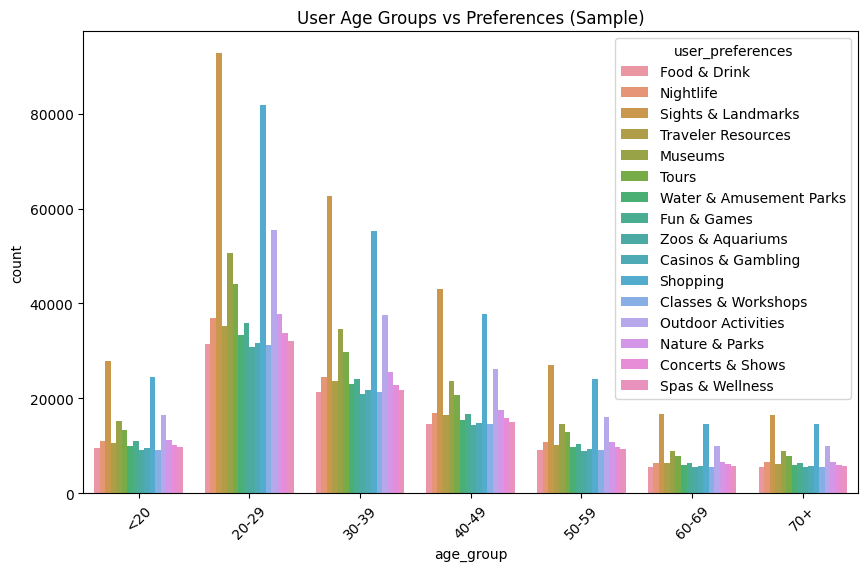

In [28]:
# Sample for plotting
df_sample = df_user_travel_to_use.sample(1_000_000, random_state=42)

# Create age bins
df_sample['age_group'] = pd.cut(
    df_sample['User_age'],
    bins=[0,20,30,40,50,60,70,80],
    labels=['<20','20-29','30-39','40-49','50-59','60-69','70+']
)

# Split preferences into multiple rows
prefs = df_sample.assign(
    user_preferences=df_sample['user_preferences'].str.split(';')
).explode('user_preferences')

# Plot
plt.figure(figsize=(10,6))
sns.countplot(data=prefs, x='age_group', hue='user_preferences')
plt.title("User Age Groups vs Preferences (Sample)")
plt.xticks(rotation=45)
plt.show()


<h2><b>Figure 2: Budget Tier Alignment Between Users and Landmarks</b></h2>

This heatmap visualizes the alignment between users' budget tiers and the budget tiers of the landmarks they visit. Each cell represents the number of visits for a specific user-landmark budget combination. Darker shades indicate higher frequencies, highlighting strong alignment for medium and low-budget users.


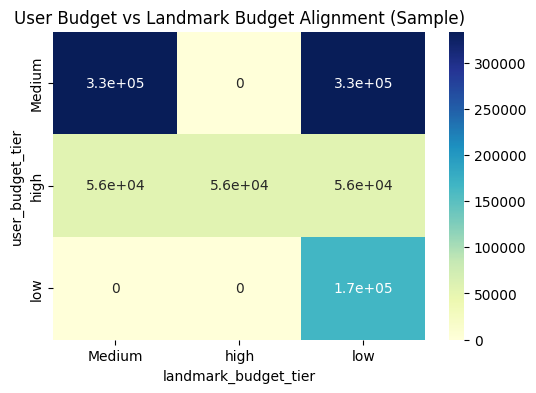

In [29]:
# Sample for plotting
df_sample = df_user_travel_to_use.sample(1_000_000, random_state=42)

# Crosstab for budget tiers
budget_matrix = pd.crosstab(
    df_sample['user_budget_tier'],
    df_sample['landmark_budget_tier']
)

# Plot heatmap
plt.figure(figsize=(6,4))
sns.heatmap(budget_matrix, annot=True, cmap="YlGnBu")
plt.title("User Budget vs Landmark Budget Alignment (Sample)")
plt.show()


<h2><b>Figure 3: Popularity of Landmark Categories</b></h2>
This horizontal bar chart ranks landmark categories by frequency of visits. It helps identify which types of attractions are most popular among users, guiding marketing and recommendation strategies.


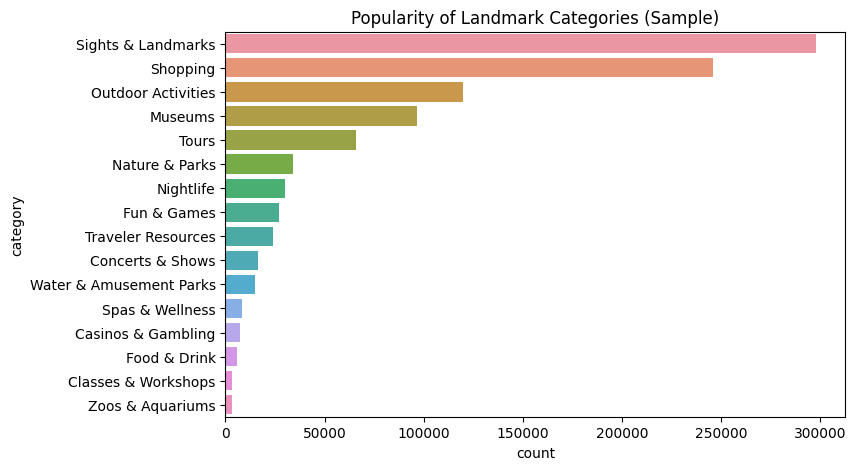

In [30]:
# Sample for plotting
df_sample = df_user_travel_to_use.sample(1_000_000, random_state=42)

# Plot category popularity
plt.figure(figsize=(8,5))
sns.countplot(
    data=df_sample,
    y='category',
    order=df_sample['category'].value_counts().index
)
plt.title("Popularity of Landmark Categories (Sample)")
plt.show()


<h2><b>Figure 4: Ratings Distribution by Category</b></h2>

This boxplot compares user ratings across different landmark categories. It reveals which categories tend to receive higher or more consistent ratings, offering insights into user satisfaction and quality perception.


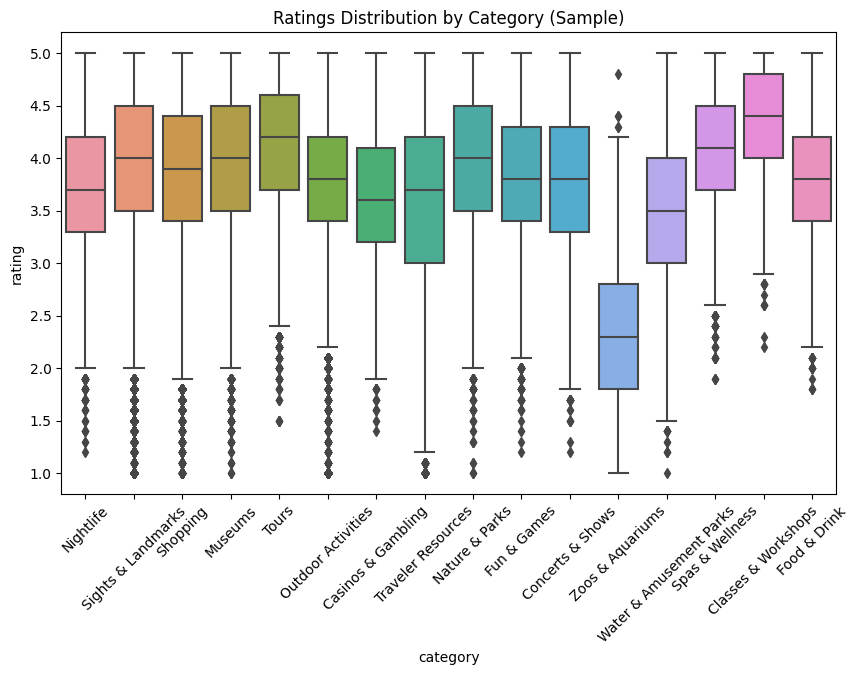

In [31]:
# Sample for plotting
df_sample = df_user_travel_to_use.sample(1_000_000, random_state=42)

# Boxplot of ratings by category
plt.figure(figsize=(10,6))
sns.boxplot(data=df_sample, x='category', y='rating')
plt.title("Ratings Distribution by Category (Sample)")
plt.xticks(rotation=45)
plt.show()


<h2><b>Figure 5: User Travel Type → Landmark Travel Type</b></h2>

This Sankey diagram illustrates the flow between user travel types and the travel types associated with the landmarks they visit. It highlights patterns such as solo travelers visiting solo-friendly landmarks, and luxury travelers exploring a mix of categories.

In [32]:
import plotly.io as pio
pio.renderers.default = "vscode"  # or "notebook"
import plotly.graph_objects as go

In [33]:
import plotly.graph_objects as go

# Sample
df_sample = df_user_travel_to_use.sample(5000, random_state=42)

# Unique user travel types
user_types = list(df_sample['user_travel_type'].unique())

# Unique landmark travel types
landmark_types = list(set(
    l.strip() for l in ";".join(df_sample['landmark_travel_type'].astype(str)).split(";") if l.strip() != ''
))

# Labels
labels = user_types + landmark_types

source, target, value = [], [], []

# Build links
for u in user_types:
    df_u = df_sample[df_sample['user_travel_type'] == u]
    for l in landmark_types:
        # Count exact matches in split landmark_travel_type
        count = df_u['landmark_travel_type'].astype(str).str.split(';') \
                .apply(lambda x: l in [s.strip() for s in x]).sum()
        if count > 0:
            source.append(labels.index(u))
            target.append(labels.index(l))
            value.append(count)

# Plot Sankey
fig = go.Figure(data=[go.Sankey(
    node=dict(pad=15, thickness=20, line=dict(color="black", width=0.5), label=labels),
    link=dict(source=source, target=target, value=value)
)])
fig.update_layout(title_text="User Travel Type → Landmark Travel Type (Sample)", font_size=10)
fig.show()


In [34]:
import plotly.io as pio
print(pio.renderers)
print("Default renderer:", pio.renderers.default)


Renderers configuration
-----------------------
    Default renderer: 'vscode'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']

Default renderer: vscode


<h2><b>Figure 6: User Age vs Rating by Category</b></h2>

This scatter plot shows how user age correlates with ratings across different landmark categories. It helps identify whether certain age groups rate specific categories more favorably, supporting targeted experience design.

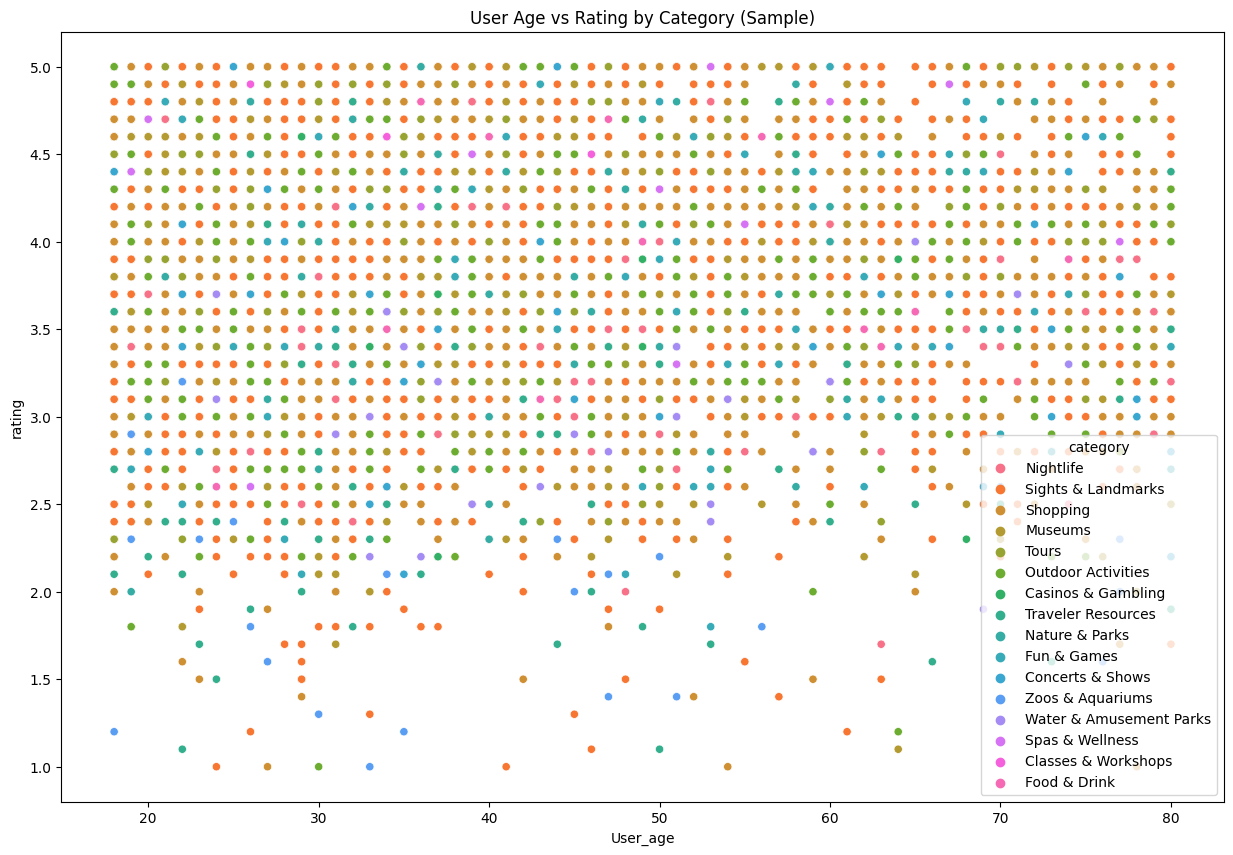

In [35]:
df_sample = df_user_travel_to_use.sample(10000, random_state=42)

plt.figure(figsize=(15,10))
sns.scatterplot(data=df_sample, x='User_age', y='rating', hue='category')
plt.title("User Age vs Rating by Category (Sample)")
plt.show()


<h2><b>Figure 7: Budget Tier vs User Travel Type</b></h2>

This grouped bar chart compares user budget tiers with their travel types. It shows how spending capacity influences travel style, such as luxury travelers tending toward higher budgets and solo travelers appearing across all tiers.

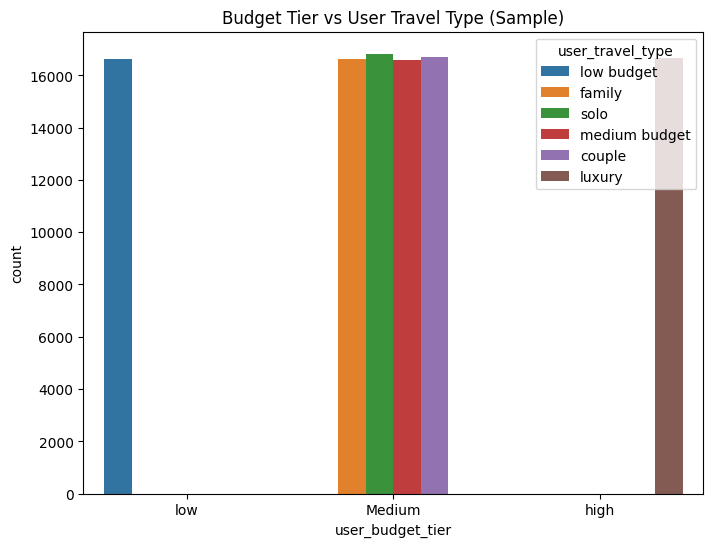

In [36]:
# Sample
df_sample = df_user_travel_to_use.sample(100_000, random_state=42)

# Count plot: Budget Tier vs User Travel Type
plt.figure(figsize=(8,6))
sns.countplot(data=df_sample, x='user_budget_tier', hue='user_travel_type')
plt.title("Budget Tier vs User Travel Type (Sample)")
plt.show()

<h2><b>Figure 8: Age Distribution by Gender</b></h2>

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warn

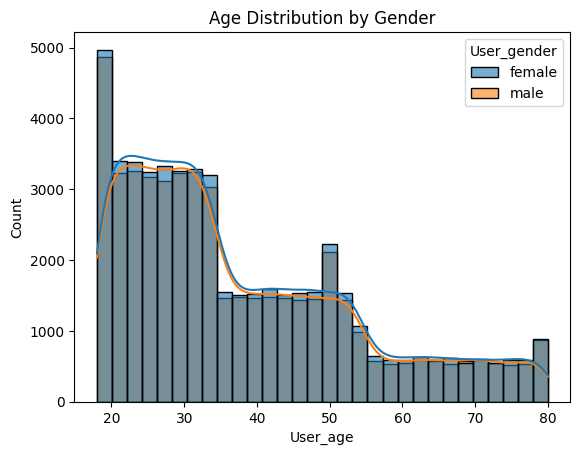

In [37]:
plt.figure()
sns.histplot(df_user_travel_to_use.sample(100000, random_state=42),
             x='User_age', hue='User_gender', bins=30, kde=True, alpha=0.6)
plt.title("Age Distribution by Gender")
plt.show()


<h2><b>Figure 9: Top 10 Landmarks by Average Rating</b></h2>

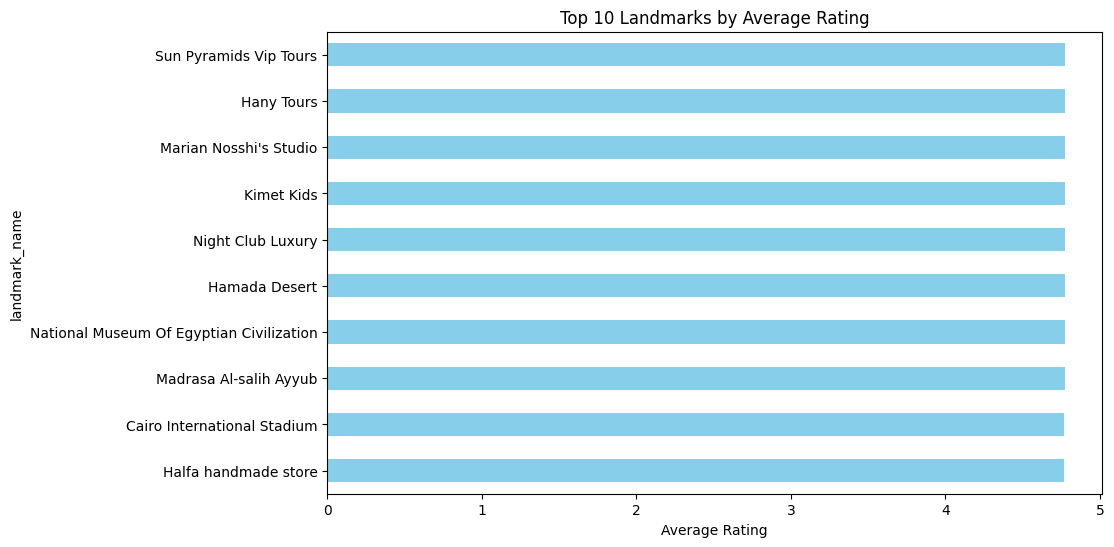

In [38]:
top_landmarks = df_user_travel_to_use.groupby('landmark_name')['rating'].mean().nlargest(10)
plt.figure(figsize=(10,6))
top_landmarks.plot(kind='barh', color='skyblue')
plt.xlabel("Average Rating")
plt.title("Top 10 Landmarks by Average Rating")
plt.gca().invert_yaxis()
plt.show()

<h2><b>Figure 10: Preference Co-Occurrence Heatmap / Top Pairs</b></h2>

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



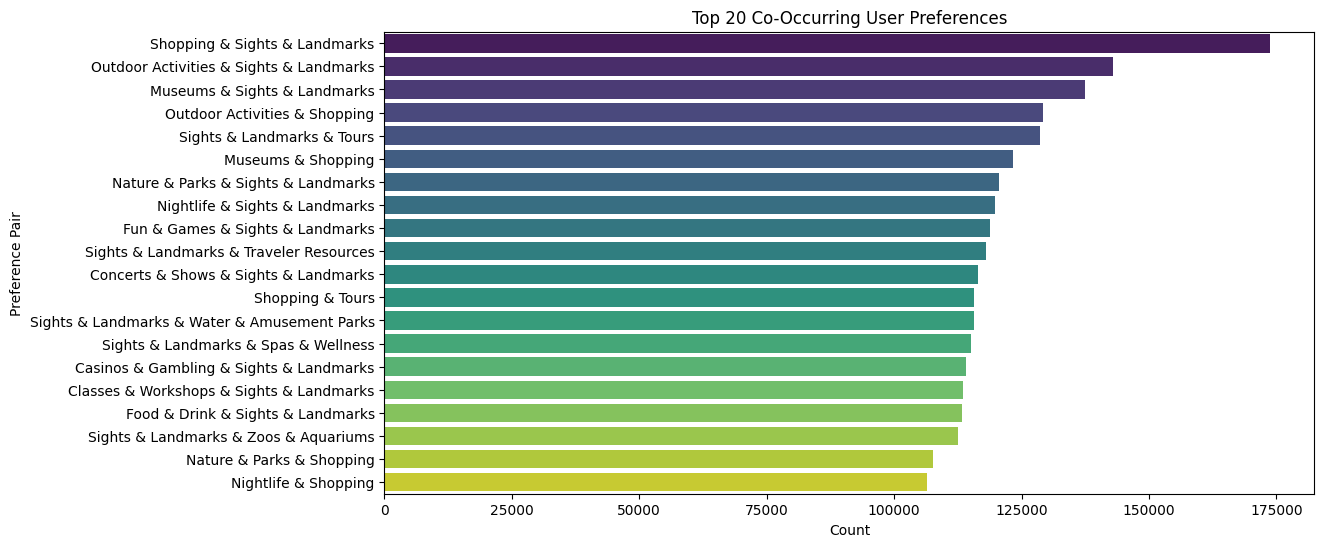

In [39]:
prefs_list = df_user_travel_to_use['user_preferences'].dropna().str.split(';')
combo_counter = Counter()

for row in prefs_list:
    row = [p.strip() for p in row if p.strip()]
    combo_counter.update(combinations(sorted(row), 2))

combo_df = pd.DataFrame(combo_counter.items(), columns=['pair','count'])
combo_df = combo_df.sort_values('count', ascending=False).head(20)

pairs = [' & '.join(p) for p in combo_df['pair']]
counts = combo_df['count']

plt.figure(figsize=(12,6))
sns.barplot(x=counts, y=pairs, palette="viridis")
plt.title("Top 20 Co-Occurring User Preferences")
plt.xlabel("Count")
plt.ylabel("Preference Pair")
plt.show()


<h2><b>Figure 11: Trip Frequency / Count by Age Group and Travel Type</b></h2>

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



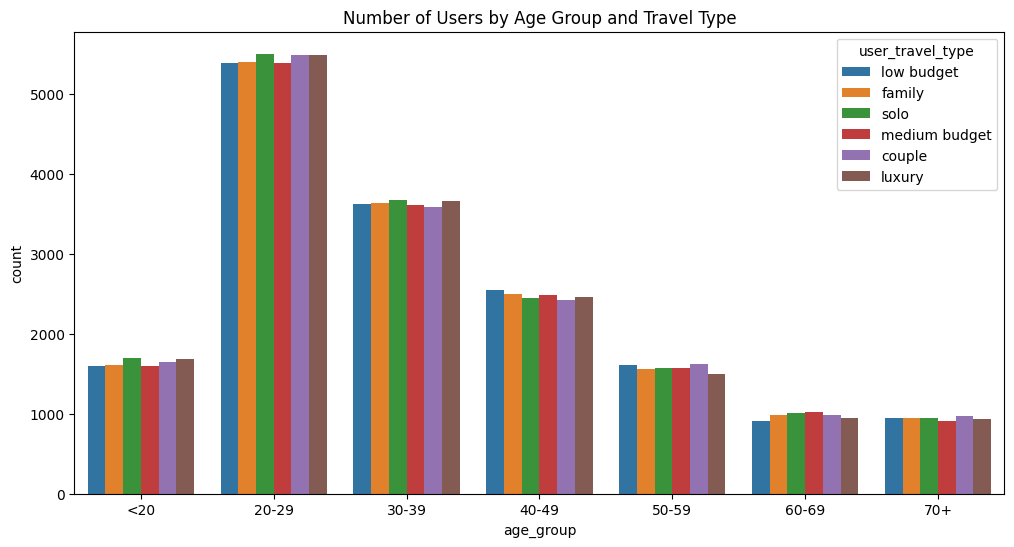

In [40]:
df_sample = df_user_travel_to_use.sample(100000, random_state=42)
plt.figure(figsize=(12,6))
sns.countplot(data=df_sample, x='age_group', hue='user_travel_type')
plt.title("Number of Users by Age Group and Travel Type")
plt.show()

<h2><b>Figure 12: Average Rating by Budget Tier </b></h2>

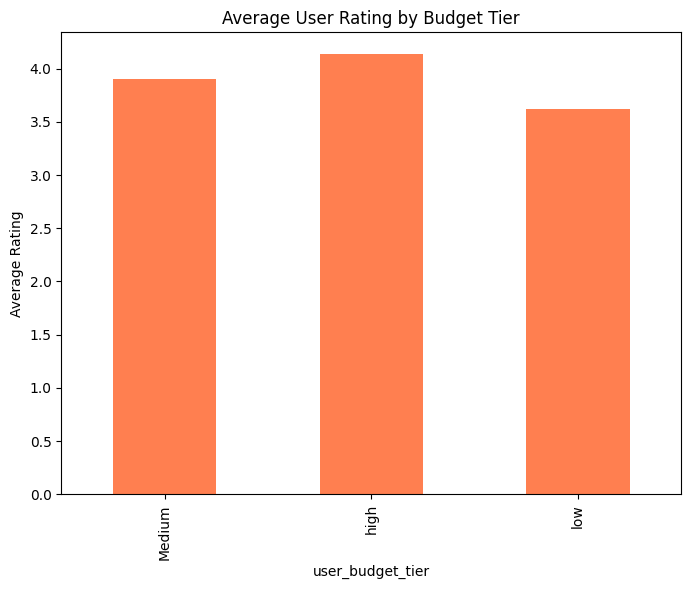

In [41]:
avg_rating_budget = df_user_travel_to_use.groupby('user_budget_tier')['rating'].mean().sort_index()
plt.figure(figsize=(8,6))
avg_rating_budget.plot(kind='bar', color='coral')
plt.ylabel("Average Rating")
plt.title("Average User Rating by Budget Tier")
plt.show()


In [42]:
train, temp = train_test_split(df_user_travel_to_use, test_size=0.3, random_state=42)
val, test = train_test_split(temp, test_size=0.5, random_state=42)

os.makedirs("data/train", exist_ok=True)
os.makedirs("data/val", exist_ok=True)
os.makedirs("data/test", exist_ok=True)

train.to_csv("data/train/train.csv", index=False)
val.to_csv("data/val/val.csv", index=False)
test.to_csv("data/test/test.csv", index=False)

In [43]:
train_data = pd.read_csv("data/train/train.csv")
val_data = pd.read_csv("data/val/val.csv")
test_data = pd.read_csv("data/test/test.csv")

### lightfm model training 1th try 

In [44]:
from lightfm import LightFM
from lightfm.data import Dataset

# Create synthetic user IDs
df_user_travel_to_use = df_user_travel_to_use.copy()
df_user_travel_to_use['user_id'] = range(len(df_user_travel_to_use))

# Flatten user preferences into a set for user features
user_features_set = set()
for prefs in df_user_travel_to_use['user_preferences']:
    user_features_set.update([p.strip() for p in prefs.split(';') if p.strip()])

# Flatten item features: category + landmark_budget_tier
item_features_set = set(df_user_travel_to_use['category'].unique()) | \
                    set(df_user_travel_to_use['landmark_budget_tier'].unique())

# Initialize LightFM dataset
dataset = Dataset()

# Fit dataset with synthetic user IDs
dataset.fit(
    users=df_user_travel_to_use['user_id'].unique(),
    items=df_user_travel_to_use['landmark_name'].unique(),
    user_features=user_features_set,
    item_features=item_features_set
)

# Build interactions (ratings)
(interactions, weights) = dataset.build_interactions(
    [(row.user_id, row.landmark_name, row.rating) for row in df_user_travel_to_use.itertuples()]
)

# Build user features
user_features = dataset.build_user_features(
    [(row.user_id, [p.strip() for p in row.user_preferences.split(';') if p.strip()])
     for row in df_user_travel_to_use.itertuples()]
)

# Build item features
item_features = dataset.build_item_features(
    [(row.landmark_name, [row.category, row.landmark_budget_tier])
     for row in df_user_travel_to_use.itertuples()]
)


In [45]:
import time
from lightfm import LightFM
from lightfm.evaluation import precision_at_k

# Split interactions into train and validation (example: 80% train, 20% validation)
from lightfm.cross_validation import random_train_test_split
train, test = random_train_test_split(interactions, test_percentage=0.2, random_state=42)

# Initialize model
model = LightFM(loss='warp')

# Training parameters
epochs = 50
num_threads = 4
early_stopping_patience = 5  # stop if no improvement in 5 epochs
best_precision = 0
patience_counter = 0

# --------------------------
# Start timing
# --------------------------
start_time = time.time()

# Training loop with manual early stopping
for epoch in range(epochs):
    model.fit_partial(train,
                      user_features=user_features,
                      item_features=item_features,
                      epochs=1,
                      num_threads=num_threads)
    
    # Evaluate on validation set
    val_precision = precision_at_k(model, test, user_features=user_features,
                                   item_features=item_features, k=10).mean()
    print(f"Epoch {epoch+1}/{epochs} - Validation precision@10: {val_precision:.4f}")
    
    # Check early stopping
    if val_precision > best_precision:
        best_precision = val_precision
        patience_counter = 0
    else:
        patience_counter += 1
    
    if patience_counter >= early_stopping_patience:
        print(f"⚠ Early stopping triggered at epoch {epoch+1}")
        break

# --------------------------
# End timing
# --------------------------
end_time = time.time()
total_time = end_time - start_time
print(f"\n⏱ Total training time: {total_time:.2f} seconds")


Epoch 1/50 - Validation precision@10: 0.0188
Epoch 2/50 - Validation precision@10: 0.0177
Epoch 3/50 - Validation precision@10: 0.0168
Epoch 4/50 - Validation precision@10: 0.0166
Epoch 5/50 - Validation precision@10: 0.0161
Epoch 6/50 - Validation precision@10: 0.0155
⚠ Early stopping triggered at epoch 6

⏱ Total training time: 225.33 seconds


In [46]:
# =============================================================================
# SAVE LIGHTFM MODEL AND FEATURES
# =============================================================================

import pickle
import json
from datetime import datetime
import pandas as pd

# Create timestamp for unique filenames
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# -------------------------------
# Save the LightFM model
# -------------------------------
lightfm_model_path = f'lightfm_model_{timestamp}.pkl'
with open(lightfm_model_path, 'wb') as f:
    pickle.dump(model, f)
print(f"✅ LightFM model saved as: {lightfm_model_path}")

# -------------------------------
# Save user_features
# -------------------------------
user_features_path = f'user_features_{timestamp}.pkl'
with open(user_features_path, 'wb') as f:
    pickle.dump(user_features, f)
print(f"✅ User features saved as: {user_features_path}")

# -------------------------------
# Save item_features
# -------------------------------
item_features_path = f'item_features_{timestamp}.pkl'
with open(item_features_path, 'wb') as f:
    pickle.dump(item_features, f)
print(f"✅ Item features saved as: {item_features_path}")

# -------------------------------
# Save dataset mapping (optional but recommended)
# -------------------------------
dataset_mapping_path = f'dataset_mapping_{timestamp}.pkl'
with open(dataset_mapping_path, 'wb') as f:
    pickle.dump(dataset.mapping(), f)
print(f"✅ Dataset mapping saved as: {dataset_mapping_path}")

# -------------------------------
# Save metadata
# -------------------------------
model_metadata = {
    'timestamp': timestamp,
    'lightfm_model_path': lightfm_model_path,
    'user_features_path': user_features_path,
    'item_features_path': item_features_path,
    'dataset_mapping_path': dataset_mapping_path,
    'model_loss': 'warp',
    'epochs': 30,
    'num_threads': 4,
    'dataset_shape': {
        'num_users': dataset.interactions_shape()[0],
        'num_items': dataset.interactions_shape()[1]
    }
}

metadata_path = f'lightfm_model_metadata_{timestamp}.json'
with open(metadata_path, 'w') as f:
    json.dump(model_metadata, f, indent=2)
print(f"✅ Model metadata saved as: {metadata_path}")

print("\n" + "="*60)
print("🎉 LIGHTFM MODEL AND FEATURES SAVED SUCCESSFULLY!")
print("="*60)


✅ LightFM model saved as: lightfm_model_20251129_205029.pkl
✅ User features saved as: user_features_20251129_205029.pkl
✅ Item features saved as: item_features_20251129_205029.pkl
✅ Dataset mapping saved as: dataset_mapping_20251129_205029.pkl
✅ Model metadata saved as: lightfm_model_metadata_20251129_205029.json

🎉 LIGHTFM MODEL AND FEATURES SAVED SUCCESSFULLY!


In [47]:
import numpy as np
from lightfm import LightFM

def recommend_landmarks(model, dataset, user_features, item_features, user_id, top_n=10):
    """
    Generate top-N landmark recommendations for a given user.
    
    Args:
        model: trained LightFM model
        dataset: LightFM Dataset object
        user_features: LightFM user features
        item_features: LightFM item features
        user_id: synthetic user_id (integer)
        top_n: number of recommendations
    
    Returns:
        List of top-N landmark names
    """
    n_users, n_items = dataset.interactions_shape()
    
    # Repeat user_id to match item_ids length
    user_ids = np.repeat(user_id, n_items)
    item_ids = np.arange(n_items)
    
    # Predict scores for all items for this user
    scores = model.predict(
        user_ids=user_ids,
        item_ids=item_ids,
        user_features=user_features,
        item_features=item_features
    )
    
    # Rank items by score
    top_items = np.argsort(-scores)[:top_n]
    
    # Map item indices back to item names
    item_id_map = dataset.mapping()[2]  # (user_id_map, item_id_map, user_feature_map, item_feature_map)
    index_to_item = {v: k for k, v in item_id_map.items()}
    top_landmarks = [index_to_item[i] for i in top_items]
    
    return top_landmarks


In [48]:
synthetic_user_id =1 # first row in your dataset

top_recommendations = recommend_landmarks(
    model,
    dataset,
    user_features,
    item_features,
    user_id=synthetic_user_id,
    top_n=10
)

print("Top 10 recommended landmarks for user_id 0:")
for idx, landmark in enumerate(top_recommendations, start=1):
    print(f"{idx}. {landmark}")


Top 10 recommended landmarks for user_id 0:
1. Umm Kolthoum Museum
2. Museo Mevlevi
3. Museum of Islamic Ceramics
4. Mostafa Kamel Museum
5. Child Museum
6. October War Panorama
7. Mohamed Nagy Museum
8. Military Museum
9. Egyptian Geology Museum
10. Le Sommet Gallery


### lightfm model training 2th try

In [49]:
import numpy as np

def recommend_landmarks_fixed(model, dataset, user_features, item_features, external_user_id, top_n=10, verbose=False):
    """
    Corrected recommender for LightFM.

    Args:
        model: trained LightFM model
        dataset: LightFM Dataset object
        user_features: user feature matrix (from dataset.build_user_features)
        item_features: item feature matrix (from dataset.build_item_features)
        external_user_id: the user id as used in your dataframe (must exist in dataset.mapping()[0])
        top_n: number of recommended items
        verbose: if True, prints debug info

    Returns:
        list of (landmark_name, score)
    """
    # Get mappings
    user_id_map, item_id_map, user_feature_map, item_feature_map = dataset.mapping()

    # Check user exists
    if external_user_id not in user_id_map:
        raise KeyError(f"User id {external_user_id} not found in dataset mapping. Available sample keys: {list(user_id_map.keys())[:10]}")

    # Map external user id -> internal index
    u_index = user_id_map[external_user_id]

    n_items = item_features.shape[0]
    item_indices = np.arange(n_items)

    # Predict scores for all items for this user (uses internal index)
    scores = model.predict(u_index, item_indices, user_features=user_features, item_features=item_features)

    # Top indices by score
    top_idx = np.argsort(-scores)[:top_n]

    # invert item_id_map (item_name -> internal_index) -> (internal_index -> item_name)
    inv_item_map = {v: k for k, v in item_id_map.items()}

    # Build (name, score) pairs
    top_items = [(inv_item_map[int(i)], float(scores[int(i)])) for i in top_idx]

    if verbose:
        print("user_index:", u_index)
        print("n_items:", n_items)
        print("top indices:", top_idx.tolist())
        print("top names (raw):", [inv_item_map[int(i)] for i in top_idx])

    return top_items


In [50]:
"""
full_recommender_lightfm_no_neo4j.py

Full end-to-end LightFM recommender (no Neo4j).
- robust CSV loading using the column names you gave
- preprocessing and multi-label parsing
- builds LightFM dataset with user/item features
- correct mapping usage (no index-mixups)
- supports cold-start users by constructing a feature vector
- local re-ranking using landmark dataframe (no DB)

Usage:
    1) pip install lightfm neo4j-driver pandas scipy scikit-learn tqdm
       (neo4j-driver not used here, but harmless; you can omit it)
    2) python full_recommender_lightfm_no_neo4j.py --csv your_dataset.csv --train
    3) Or import functions from this file in a notebook.

Notes:
- Expected columns (based on your message):
    User_gender
    user_preferences
    user_budget_tier
    landmark_budget_tier
    category
    rating
    landmark_name
    user_travel_type
    landmaek_travel_type

  The script will also accept common variants: user_id, User_id, user_age, User_age.
- If user_id is missing, a synthetic user_id is created from the dataframe index.
- Cold-start: If a user isn't present in training interactions, the script will compute a user embedding
  from the provided user features and score items via dot-product with item embeddings.
"""

from typing import List, Dict, Any, Tuple, Optional
import pandas as pd
import numpy as np
from lightfm import LightFM
from lightfm.data import Dataset as LFMDataset
from scipy import sparse
import pickle
import argparse
import logging
import os

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


# ---------- helpers ----------
def parse_multi_label(cell: Any) -> List[str]:
    """Parse a multi-label cell into list of strings. Accepts '|', ',' or ';' separators."""
    if pd.isna(cell):
        return []
    if isinstance(cell, (list, tuple, set)):
        return [str(x).strip() for x in cell if str(x).strip()]
    if isinstance(cell, str):
        # prefer '|' if present, else semicolon, else comma
        if '|' in cell:
            parts = [p.strip() for p in cell.split('|') if p.strip()]
            return parts
        if ';' in cell:
            parts = [p.strip() for p in cell.split(';') if p.strip()]
            return parts
        if ',' in cell:
            parts = [p.strip() for p in cell.split(',') if p.strip()]
            return parts
        s = cell.strip()
        return [s] if s else []
    return [str(cell).strip()]


def detect_columns(df: pd.DataFrame) -> Dict[str, str]:
    """Return mapping from canonical name -> actual column in df."""
    cols = {c.lower(): c for c in df.columns}
    mapping = {}

    # user id
    for k in ('user_id', 'userid', 'user id', 'User_id', 'UserID'):
        if k.lower() in cols:
            mapping['user_id'] = cols[k.lower()]
            break

    # user age (optional)
    for k in ('user_age', 'age', 'userage', 'User_age'):
        if k.lower() in cols:
            mapping['user_age'] = cols[k.lower()]
            break

    # other columns provided by user (use exact names they gave if present)
    expected = [
        ('User_gender', ['user_gender', 'User_gender', 'gender']),
        ('user_preferences', ['user_preferences', 'preferences', 'User_preferences']),
        ('user_budget_tier', ['user_budget_tier', 'user_budget']),
        ('landmark_budget_tier', ['landmark_budget_tier', 'landmarkbudgettier']),
        ('category', ['category']),
        ('rating', ['rating', 'score']),
        ('landmark_name', ['landmark_name', 'name']),
        ('user_travel_type', ['user_travel_type', 'travel_type']),
        # user spelled it 'landmaek_travel_type' — accept both
        ('landmaek_travel_type', ['landmaek_travel_type', 'landmark_travel_type', 'landmarktraveltype'])
    ]

    for canon, variants in expected:
        found = False
        for v in variants:
            if v.lower() in cols:
                mapping[canon] = cols[v.lower()]
                found = True
                break
        if not found:
            # leave absent; some fields are optional
            mapping[canon] = None

    return mapping


# ---------- preprocessing ----------
def preprocess(df: pd.DataFrame) -> Tuple[pd.DataFrame, Dict[str, str]]:
    """Clean dataframe and return it plus detected column mapping."""
    df = df.copy()
    colmap = detect_columns(df)

    # If no user_id, create synthetic one
    if not colmap.get('user_id'):
        logger.warning('No user_id column detected. Creating synthetic user_id from row index.')
        df = df.reset_index(drop=True)
        df['user_id'] = df.index.astype(int)
        colmap['user_id'] = 'user_id'

    # If user_age present convert to numeric and enforce >=18 (if present)
    if colmap.get('user_age'):
        df[colmap['user_age']] = pd.to_numeric(df[colmap['user_age']], errors='coerce')
        df = df[df[colmap['user_age']] >= 18]
    else:
        logger.info('user_age not present; age-based features will be skipped.')

    # Standardize gender column
    if colmap.get('User_gender'):
        gcol = colmap['User_gender']
        df[gcol] = df[gcol].astype(str).str.lower().str.strip()
        # keep only male/female if present
        df = df[df[gcol].isin(['male', 'female']) | df[gcol].isna()]

    # Multi-label fields
    if colmap.get('user_preferences'):
        df['user_preferences_list'] = df[colmap['user_preferences']].apply(parse_multi_label)
    else:
        df['user_preferences_list'] = [[] for _ in range(len(df))]

    # landmark travel types (note spelling)
    if colmap.get('landmaek_travel_type'):
        df['landmark_travel_type_list'] = df[colmap['landmaek_travel_type']].apply(parse_multi_label)
    else:
        df['landmark_travel_type_list'] = [[] for _ in range(len(df))]

    # Ratings numeric
    if colmap.get('rating'):
        df[colmap['rating']] = pd.to_numeric(df[colmap['rating']], errors='coerce')
        df = df.dropna(subset=[colmap['rating']])
    else:
        raise ValueError('rating column not found. It is required.')

    # Landmark name
    if not colmap.get('landmark_name'):
        raise ValueError('landmark_name column not found. It is required.')
    df['landmark_name'] = df[colmap['landmark_name']].astype(str).str.strip()

    # category and budget tiers - optional but helpful
    if colmap.get('category'):
        df['category'] = df[colmap['category']].astype(str).str.strip()
    else:
        df['category'] = 'Unknown'

    if colmap.get('landmark_budget_tier'):
        df['landmark_budget_tier'] = df[colmap['landmark_budget_tier']].astype(str).str.strip()
    else:
        df['landmark_budget_tier'] = ''

    if colmap.get('user_budget_tier'):
        df['user_budget_tier'] = df[colmap['user_budget_tier']].astype(str).str.strip()
    else:
        df['user_budget_tier'] = ''

    if colmap.get('user_travel_type'):
        df['user_travel_type'] = df[colmap['user_travel_type']].astype(str).str.strip()
    else:
        df['user_travel_type'] = ''

    # Make sure user_id is consistent type
    df['user_id'] = df[colmap['user_id']].astype(int)

    df = df.reset_index(drop=True)
    logger.info("Preprocessed: %d rows, %d unique users, %d unique landmarks",
                len(df), df['user_id'].nunique(), df['landmark_name'].nunique())
    return df, colmap


# ---------- LightFM dataset builder ----------
def build_lightfm_meta(df: pd.DataFrame) -> Dict[str, Any]:
    """
    Build LFMDataset, interactions, and feature matrices.
    Returns dict with dataset, interactions, weights, user_features, item_features, mappings.
    """
    dataset = LFMDataset()

    users = df['user_id'].unique().tolist()
    items = df['landmark_name'].unique().tolist()

    # collect feature vocabularies
    user_feature_set = set()
    item_feature_set = set()
    user_feat_map: Dict[int, List[str]] = {}
    item_feat_map: Dict[str, List[str]] = {}

    # user features
    for uid, g in df.groupby('user_id'):
        row = g.iloc[0]
        feats = []

        # age buckets (if age present)
        if 'user_age' in df.columns and 'user_age' in g.columns and not g['user_age'].isnull().all():
            age = int(row.get('user_age', 0) if not pd.isna(row.get('user_age')) else 0)
            if age >= 18 and age < 25:
                feats.append('age:18-24')
            elif age < 35:
                feats.append('age:25-34')
            elif age < 50:
                feats.append('age:35-49')
            elif age > 0:
                feats.append('age:50+')

        # gender
        if 'User_gender' in df.columns:
            gen = row.get('User_gender', '')
            if gen:
                feats.append('gender:' + str(gen))

        # travel type
        if 'user_travel_type' in row and row['user_travel_type']:
            feats.append('user_travel_type:' + str(row['user_travel_type']))

        # user budget pref
        if 'user_budget_tier' in row and row.get('user_budget_tier'):
            feats.append('user_budget:' + str(row['user_budget_tier']))

        # preferences (multi)
        prefs = set([p for prefs in g['user_preferences_list'] for p in prefs])
        for p in prefs:
            if p:
                feats.append('pref:' + p)

        for f in feats:
            user_feature_set.add(f)
        user_feat_map[uid] = feats

    # item features
    for item_name, g in df.groupby('landmark_name'):
        row = g.iloc[0]
        feats = []
        feats.append('cat:' + str(row.get('category', 'Unknown')))
        feats.append('budget:' + str(row.get('landmark_budget_tier', '')))
        travel_types = set([t for types in g['landmark_travel_type_list'] for t in types])
        for t in travel_types:
            if t:
                feats.append('item_travel_type:' + t)
        for f in feats:
            item_feature_set.add(f)
        item_feat_map[item_name] = feats

    # Fit dataset
    dataset.fit(users=users, items=items,
                user_features=list(user_feature_set), item_features=list(item_feature_set))

    # interactions - use rating as weight
    interactions_input = ((row['user_id'], row['landmark_name'], float(row['rating'])) for idx, row in df.iterrows())
    interactions, weights = dataset.build_interactions(interactions_input)

    # build feature matrices
    def user_feat_gen():
        for uid in users:
            yield (uid, user_feat_map.get(uid, []))

    def item_feat_gen():
        for iid in items:
            yield (iid, item_feat_map.get(iid, []))

    user_features = dataset.build_user_features(user_feat_gen())
    item_features = dataset.build_item_features(item_feat_gen())

    user_id_map, item_id_map, user_feature_map, item_feature_map = dataset.mapping()

    meta = {
        'dataset': dataset,
        'interactions': interactions,
        'weights': weights,
        'user_features': user_features,
        'item_features': item_features,
        'user_id_map': user_id_map,
        'item_id_map': item_id_map,
        'user_feature_map': user_feature_map,
        'item_feature_map': item_feature_map
    }
    logger.info("Built LightFM dataset and feature matrices")
    return meta


# ---------- training ----------
def train_lightfm(meta: Dict[str, Any], no_components: int = 64, epochs: int = 20, learning_rate: float = 0.05, loss: str = 'warp') -> LightFM:
    model = LightFM(no_components=no_components, learning_rate=learning_rate, loss=loss)
    logger.info("Training LightFM model (this may take a while)...")
    model.fit(meta['interactions'], sample_weight=meta['weights'],
              user_features=meta['user_features'], item_features=meta['item_features'],
              epochs=epochs, num_threads=4)
    logger.info("Training finished")
    return model


# ---------- correct recommend function (handles cold-start) ----------
def recommend_for_user(model: LightFM, meta: Dict[str, Any], df_landmarks: pd.DataFrame,
                       external_user: int, user_profile: Optional[Dict[str, Any]] = None,
                       topk_candidates: int = 50, top_n: int = 10) -> List[Dict[str, Any]]:
    """
    Produces top_n recommended landmarks for external_user.
    If external_user exists in training mapping, uses model.predict for speed.
    If not, constructs a user_features vector and computes scores via representation dot-product.
    Returns list of dicts: {'landmark_name','score','debug'}
    """
    user_id_map = meta['user_id_map']
    item_id_map = meta['item_id_map']
    user_feature_map = meta['user_feature_map']

    # Get item representations for cold-start scoring if needed
    item_embeddings, item_biases = model.get_item_representations(item_features=meta['item_features'])

    # helper: inverse item map index->name
    inv_item_map = {v: k for k, v in item_id_map.items()}

    # Case A: existing user (was in training)
    if external_user in user_id_map:
        u_index = user_id_map[external_user]
        n_items = meta['item_features'].shape[0]
        item_indices = np.arange(n_items)
        scores = model.predict(u_index, item_indices, user_features=meta['user_features'], item_features=meta['item_features'])
        # topk candidates
        top_idx = np.argsort(-scores)[:topk_candidates]
        candidates = [(inv_item_map[int(i)], float(scores[int(i)])) for i in top_idx]
        debug_source = 'trained_user'
    else:
        # Case B: cold-start user -> need user_profile to compute features
        if user_profile is None:
            raise ValueError("User is cold-start (not in training). Provide user_profile dict with keys: "
                             "user_travel_type, user_budget_tier, preferences (list), gender (optional), age (optional).")
        # Build user feature vector (sparse row) using user_feature_map
        n_user_feats = max(user_feature_map.values()) + 1 if user_feature_map else 0
        row = []
        col = []
        data = []
        # helper to set feature
        def set_feat(feat_str):
            if feat_str in user_feature_map:
                col.append(user_feature_map[feat_str])
                data.append(1.0)
        # age bucket
        age = user_profile.get('age')
        if age:
            if age >= 18 and age < 25:
                set_feat('age:18-24')
            elif age < 35:
                set_feat('age:25-34')
            elif age < 50:
                set_feat('age:35-49')
            else:
                set_feat('age:50+')
        # gender
        gender = user_profile.get('gender')
        if gender:
            set_feat('gender:' + str(gender).lower())
        # travel type
        utt = user_profile.get('user_travel_type')
        if utt:
            set_feat('user_travel_type:' + str(utt))
        # user budget
        ub = user_profile.get('user_budget_tier')
        if ub:
            set_feat('user_budget:' + str(ub))
        # preferences
        prefs = user_profile.get('preferences', [])
        for p in prefs:
            if p:
                set_feat('pref:' + str(p))
        if len(data) == 0:
            # no features matched the known vocabulary; produce unpersonalized baseline scores (item popularity or embedding bias)
            logger.warning("Cold-start user features did not match training vocabulary. Returning item bias-ranked items.")
            # fallback: score by item_biases
            scores = item_biases.ravel()
        else:
            user_feat_vec = sparse.csr_matrix((data, (row, col)), shape=(1, n_user_feats))
            # compute user embedding via model
            user_embedding, user_bias = model.get_user_representations(user_features=user_feat_vec)
            # user_embedding shape -> (1, EMB)
            # compute dot product with all item embeddings: (n_items, EMB) @ (EMB,) or transpose as needed
            # item_embeddings shape is (n_items, EMB)
            # compute scores = item_embeddings dot user_embedding.T + item_biases + user_bias
            # reshape appropriately
            u_emb = user_embedding[0]  # (EMB,)
            u_bias = user_bias[0][0] if user_bias.size else 0.0
            scores = item_embeddings.dot(u_emb) + item_biases.ravel() + u_bias

        # topk candidates
        top_idx = np.argsort(-scores)[:topk_candidates]
        candidates = [(inv_item_map[int(i)], float(scores[int(i)])) for i in top_idx]
        debug_source = 'cold_start_user'

    # Local re-ranking using df_landmarks features (category, travel types, budget, rating)
    # Build small df of candidates
    cand_df = df_landmarks[df_landmarks['landmark_name'].isin([c for c, s in candidates])].drop_duplicates('landmark_name').set_index('landmark_name')
    # baseline: model score
    cand_scores = {name: score for name, score in candidates}
    cand_df['model_score'] = cand_df.index.map(cand_scores)

    # compute heuristic boosts
    # Use user_profile if provided or try to pick from df rows for existing user
    if external_user in user_id_map:
        # try to infer user profile from df: pick first row for that user
        rows = df_landmarks[df_landmarks['user_id'] == external_user] if 'user_id' in df_landmarks.columns else pd.DataFrame()
        if not rows.empty:
            sample = rows.iloc[0]
            uprefs = sample.get('user_preferences_list', [])
            utr = sample.get('user_travel_type', '')
            ubud = sample.get('user_budget_tier', '')
        else:
            uprefs = user_profile.get('preferences', []) if user_profile else []
            utr = user_profile.get('user_travel_type', '') if user_profile else ''
            ubud = user_profile.get('user_budget_tier', '') if user_profile else ''
    else:
        uprefs = user_profile.get('preferences', []) if user_profile else []
        utr = user_profile.get('user_travel_type', '') if user_profile else ''
        ubud = user_profile.get('user_budget_tier', '') if user_profile else ''

    def travel_overlap_score(row):
        try:
            tlist = row.get('landmark_travel_type_list', [])
            return 1.0 if utr and utr in tlist else 0.0
        except Exception:
            return 0.0

    def pref_score(row):
        try:
            cat = row.get('category', '')
            return 1.0 if cat in uprefs else 0.0
        except Exception:
            return 0.0

    def budget_score(row):
        try:
            return 1.0 if ubud and ubud == row.get('landmark_budget_tier') else 0.0
        except Exception:
            return 0.0

    cand_df['travel_overlap'] = cand_df.apply(travel_overlap_score, axis=1)
    cand_df['pref_match'] = cand_df.apply(pref_score, axis=1)
    cand_df['budget_match'] = cand_df.apply(budget_score, axis=1)
    # rating normalized (0..1)
    if 'rating' in cand_df.columns:
        minr = cand_df['rating'].min() if cand_df['rating'].notnull().any() else 0.0
        maxr = cand_df['rating'].max() if cand_df['rating'].notnull().any() else 1.0
        denom = maxr - minr if maxr > minr else 1.0
        cand_df['rating_norm'] = (cand_df['rating'] - minr) / denom
    else:
        cand_df['rating_norm'] = 0.0

    # Combine scores
    # Tunable weights
    w_model = 0.6
    w_pref = 0.15
    w_travel = 0.15
    w_budget = 0.05
    w_rating = 0.05

    cand_df['final_score'] = (w_model * cand_df['model_score'].fillna(0)
                              + w_pref * cand_df['pref_match']
                              + w_travel * cand_df['travel_overlap']
                              + w_budget * cand_df['budget_match']
                              + w_rating * cand_df['rating_norm'])

    # produce top_n
    final = cand_df.sort_values('final_score', ascending=False).head(top_n)
    out = []
    for name, row in final.iterrows():
        out.append({
            'landmark_name': name,
            'score': float(row['final_score']),
            'components': {
                'model_score': float(row['model_score']) if not pd.isna(row['model_score']) else None,
                'pref_match': float(row['pref_match']),
                'travel_overlap': float(row['travel_overlap']),
                'budget_match': float(row['budget_match']),
                'rating_norm': float(row['rating_norm'])
            }
        })
    return out


# ---------- save / load helpers ----------
def save_model(model: LightFM, meta: Dict[str, Any], model_path: str = 'lightfm_model.pkl', meta_path: str = 'lfm_meta.pkl'):
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)
    # save mapping + shapes
    serial = {
        'user_id_map': meta['user_id_map'],
        'item_id_map': meta['item_id_map'],
        'user_feature_map': meta['user_feature_map'],
        'item_feature_map': meta['item_feature_map'],
        'user_features_shape': meta['user_features'].shape,
        'item_features_shape': meta['item_features'].shape
    }
    with open(meta_path, 'wb') as f:
        pickle.dump(serial, f)
    logger.info("Saved model and meta to disk.")


def load_model(model_path: str = 'lightfm_model.pkl', meta_path: str = 'lfm_meta.pkl'):
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    with open(meta_path, 'rb') as f:
        meta_serial = pickle.load(f)
    return model, meta_serial


# ---------- CLI-style main ----------
def main(csv_path: str, train: bool = False, model_path: str = 'lightfm_model.pkl', meta_path: str = 'lfm_meta.pkl'):
    # load csv
    df = pd.read_csv(csv_path)
    df_proc, colmap = preprocess(df)

    # For re-ranking we need the original df rows to include landmark_name and features.
    # We'll keep df_proc as df_landmarks when using recommend_for_user.
    df_landmarks = df_proc.copy()

    # build and train
    meta = build_lightfm_meta(df_proc)
    if train:
        model = train_lightfm(meta, no_components=64, epochs=20, learning_rate=0.05, loss='warp')
        save_model(model, meta, model_path, meta_path)
    else:
        if os.path.exists(model_path):
            model, _ = load_model(model_path, meta_path)
            logger.info("Loaded pretrained model.")
        else:
            logger.info("No pretrained model found. Training now.")
            model = train_lightfm(meta, no_components=64, epochs=20, learning_rate=0.05, loss='warp')
            save_model(model, meta, model_path, meta_path)

    # Example: pick a sample user (first user in df)
    sample_user = df_proc['user_id'].iloc[0]
    # if sample_user not in training mapping, build profile from df row
    user_profile = None
    if sample_user not in meta['user_id_map']:
        # pick first occurrence row to construct profile
        r = df_proc[df_proc['user_id'] == sample_user].iloc[0]
        user_profile = {
            'age': int(r['user_age']) if 'user_age' in r and not pd.isna(r['user_age']) else None,
            'gender': r['User_gender'] if 'User_gender' in r else None,
            'user_travel_type': r['user_travel_type'] if 'user_travel_type' in r else None,
            'user_budget_tier': r.get('user_budget_tier', None),
            'preferences': r.get('user_preferences_list', [])
        }

    recommendations = recommend_for_user(model, meta, df_landmarks, sample_user, user_profile=user_profile, topk_candidates=100, top_n=10)
    print("Top recommendations for user", sample_user)
    for i, rec in enumerate(recommendations, 1):
        print(f"{i:02d}. {rec['landmark_name']} (score={rec['score']:.4f}) components={rec['components']}")


# ---------- run if script ----------
if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='LightFM recommender (no Neo4j)')
    parser.add_argument('--csv', required=True, help='Path to CSV dataset')
    parser.add_argument('--train', action='store_true', help='Train model (otherwise will try to load model file)')
    parser.add_argument('--model_path', default='lightfm_model.pkl')
    parser.add_argument('--meta_path', default='lfm_meta.pkl')
    args = parser.parse_args()
    main(args.csv, train=args.train, model_path=args.model_path, meta_path=args.meta_path)


usage: colab_kernel_launcher.py [-h] --csv CSV [--train]
                                [--model_path MODEL_PATH]
                                [--meta_path META_PATH]
colab_kernel_launcher.py: error: the following arguments are required: --csv


SystemExit: 2

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning:

To exit: use 'exit', 'quit', or Ctrl-D.

